In [1]:
from sklearn.datasets import fetch_20newsgroups
import matplotlib.pyplot as plt

import numpy as np
np.random.seed(42)
import random
random.seed(42)

# Question 1: Histogram of Training Documents

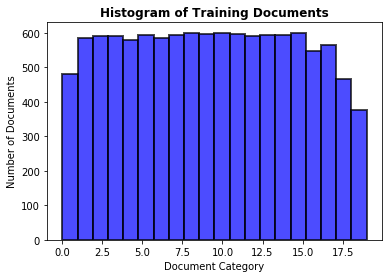

In [104]:
newsgroups = fetch_20newsgroups(subset = 'train')

plt.hist(newsgroups.target, bins=20, facecolor='blue', alpha = 0.7, edgecolor='black', linewidth=2)
plt.xlabel('Document Category')
plt.ylabel('Number of Documents')
plt.title('Histogram of Training Documents', fontweight='bold')
plt.show()
# plt.savefig('hist.png')

# Question 2: Feature Extraction

In [3]:
categories = ['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware',
'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey']

train_dataset = fetch_20newsgroups(subset = 'train', categories = categories, shuffle = True, random_state = None)
test_dataset = fetch_20newsgroups(subset = 'test', categories = categories, shuffle = True, random_state = None)

In [123]:
import nltk
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')

from nltk import pos_tag
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

from nltk.corpus import wordnet as wn
from collections import defaultdict

# pos_tags: treebank to wordnet
tag_map = defaultdict(lambda: wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

wnl = WordNetLemmatizer()

    
def lemmatize(data):
    lemmatized = []
    for doc in data:
        tokens = word_tokenize(doc)
        words = [wnl.lemmatize(word, tag_map[tag[0]]) for word,tag in pos_tag(tokens) 
                 if wnl.lemmatize(word, tag_map[tag[0]]).isalpha()]
        sentence = ' '.join(words)
        lemmatized.append(sentence)
    return lemmatized

In [109]:
train_dataset_lemmatized = lemmatize(train_dataset.data)
test_dataset_lemmatized = lemmatize(test_dataset.data)

In [110]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

vectorizer = CountVectorizer(stop_words = 'english', min_df = 3)
X_train_counts = vectorizer.fit_transform(train_dataset_lemmatized)
X_test_counts = vectorizer.transform(test_dataset_lemmatized)

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

In [111]:
print(X_train_counts.shape, X_test_counts.shape)

(4732, 12609) (3150, 12609)


# Question 3: Dimensionality Reduction

In [124]:
# Latent Semantic Indexing
from sklearn.decomposition import TruncatedSVD

lsi = TruncatedSVD(n_components = 50)
X_train_LSI = lsi.fit_transform(X_train_tfidf)
X_test_LSI = lsi.transform(X_test_tfidf)

USigmaVt = lsi.inverse_transform(X_train_LSI)
LSI_frobenius = np.sum(np.array(X_train_tfidf - USigmaVt)**2)
print("Squared Frobenius Norm for LSI: " + str(LSI_frobenius))

Squared Frobenius Norm for LSI: 4120.021460301468


In [125]:
# Non-negativee Matrix Factorization
from sklearn.decomposition import NMF

nmf = NMF(n_components=50)
X_train_NMF = nmf.fit_transform(X_train_tfidf)
X_test_NMF = nmf.transform(X_test_tfidf)

WH = np.dot(X_train_NMF, nmf.components_)
NMF_frobenius = np.sum(np.array(X_train_tfidf - WH)**2)
print("Squared Frobenius Norm for NMF: " + str(NMF_frobenius))

Squared Frobenius Norm for NMF: 4155.758160161303


# Question 4: Classification Algorithms SVM

In [116]:
Y_train_binary = np.zeros(train_dataset.target.shape)
Y_test_binary = np.zeros(test_dataset.target.shape)

Y_train_binary[train_dataset.target > 3] = 1
Y_test_binary[test_dataset.target > 3] = 1

In [131]:
train_dataset.target[:20]

array([6, 7, 4, 2, 1, 3, 0, 7, 5, 3, 0, 5, 5, 5, 3, 1, 3, 0, 0, 2])

In [132]:
Y_train_binary[:20]

array([1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0.,
       0., 0., 0.])

In [118]:
from sklearn.svm import SVC

svm_hard = SVC(C=1000, kernel='linear')
svm_soft = SVC(C=0.0001, kernel='linear')

# model training
svm_hard.fit(X_train_LSI, Y_train_binary)
svm_soft.fit(X_train_LSI, Y_train_binary)

SVC(C=0.0001, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [119]:
Y_test_prob_hard = svm_hard.decision_function(X_test_LSI)
Y_test_label_hard = svm_hard.predict(X_test_LSI)
Y_test_prob_soft = svm_soft.decision_function(X_test_LSI)
Y_test_label_soft = svm_soft.predict(X_test_LSI)

In [120]:
from sklearn.metrics import roc_curve

fpr_hard, tpr_hard, _ = roc_curve(Y_test_binary, Y_test_prob_hard)
fpr_soft, tpr_soft, _ = roc_curve(Y_test_binary, Y_test_prob_soft)

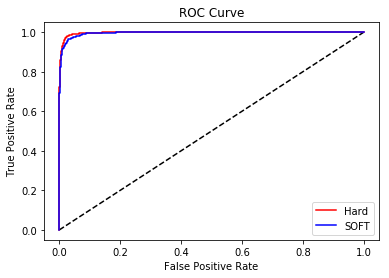

In [121]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_hard, tpr_hard, label = 'Hard', color = 'r')
plt.plot(fpr_soft, tpr_soft, label = 'SOFT', color = 'b')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

In [122]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

print('Hard Margin Linear SVMs:')
print('confusion_matrix:\n', confusion_matrix(Y_test_binary, Y_test_label_hard))
print('accuracy:', accuracy_score(Y_test_binary, Y_test_label_hard))
print('recall:', recall_score(Y_test_binary, Y_test_label_hard))
print('precision:', precision_score(Y_test_binary, Y_test_label_hard))
print('f1_score:', f1_score(Y_test_binary, Y_test_label_hard))
print('\n')
print('Soft Margin Linear SVMs:')
print('confusion_matrix:\n', confusion_matrix(Y_test_binary, Y_test_label_soft))
print('accuracy:', accuracy_score(Y_test_binary, Y_test_label_soft))
print('recall:', recall_score(Y_test_binary, Y_test_label_soft))
print('precision:', precision_score(Y_test_binary, Y_test_label_soft))
print('f1_score:', f1_score(Y_test_binary, Y_test_label_soft))

Hard Margin Linear SVMs:
confusion_matrix:
 [[1510   50]
 [  27 1563]]
accuracy: 0.9755555555555555
recall: 0.9830188679245283
precision: 0.9690018598884067
f1_score: 0.9759600374648767


Soft Margin Linear SVMs:
confusion_matrix:
 [[   0 1560]
 [   0 1590]]
accuracy: 0.5047619047619047
recall: 1.0
precision: 0.5047619047619047
f1_score: 0.6708860759493671


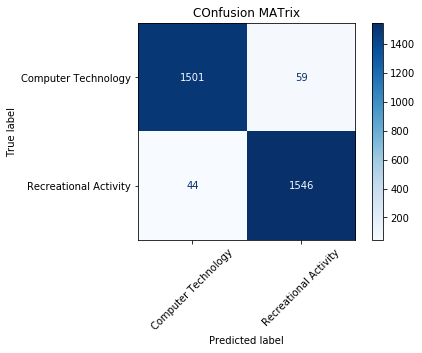

In [38]:
from sklearn.metrics import plot_confusion_matrix

class_names = ['Computer Technology', 'Recreational Activity']

plot_confusion_matrix(svm_hard, X_test_LSI, Y_test_binary, display_labels=class_names, 
                             values_format='d', xticks_rotation=45, cmap=plt.cm.Blues)

plt.title('COnfusion MATrix')
plt.show()

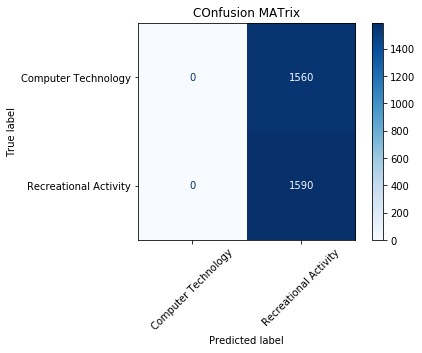

In [39]:
plot_confusion_matrix(svm_soft, X_test_LSI, Y_test_binary, display_labels=class_names, 
                             values_format='d', xticks_rotation=45, cmap=plt.cm.Blues)

plt.title('COnfusion MATrix')
plt.show()

In [40]:
# Cross Validation
from sklearn.model_selection import GridSearchCV

svm_cv = GridSearchCV(estimator=SVC(kernel='linear', probability=True), 
                      param_grid={'C':[10**-3,10**-2,10**-1,10**0,10**1,10**2,10**3]}, cv=5)

svm_cv.fit(X_train_LSI, Y_train_binary)

GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='linear', max_iter=-1,
                           probability=True, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [41]:
import pandas as pd
pd.DataFrame(svm_cv.cv_results_)[['param_C','mean_test_score']] # best C: 10

,param_C,mean_test_score
0,0.001,0.504861
1,0.01,0.505283
2,0.1,0.963441
3,1,0.970415
4,10,0.971048
5,100,0.970835
6,1000,0.972316


In [42]:
svm_best = SVC(C=svm_cv.best_params_['C'], kernel='linear')
svm_best.fit(X_train_LSI, Y_train_binary)

SVC(C=1000, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [43]:
Y_test_label_best = svm_best.predict(X_test_LSI)
Y_test_prob_best = svm_best.decision_function(X_test_LSI)

print('confusion_matrix:\n', confusion_matrix(Y_test_binary, Y_test_label_best))
print('accuracy:', accuracy_score(Y_test_binary, Y_test_label_best))
print('recall:', recall_score(Y_test_binary, Y_test_label_best))
print('precision:', precision_score(Y_test_binary, Y_test_label_best))
print('f1_score:', f1_score(Y_test_binary, Y_test_label_best))

confusion_matrix:
 [[1501   59]
 [  44 1546]]
accuracy: 0.9673015873015873
recall: 0.9723270440251572
precision: 0.9632398753894081
f1_score: 0.9677621283255086


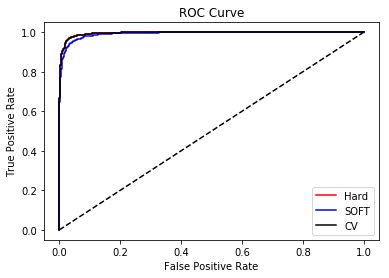

In [44]:
fpr_best, tpr_best, _ = roc_curve(Y_test_binary, Y_test_prob_best)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_hard, tpr_hard, label = 'Hard', color = 'r')
plt.plot(fpr_soft, tpr_soft, label = 'SOFT', color = 'b')
plt.plot(fpr_best, tpr_best, label = 'CV', color = 'k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

# Question 5: Logistic Regression

In [45]:
from sklearn.linear_model import LogisticRegression

# without regularization
logistic_raw = LogisticRegression(penalty='none', solver='newton-cg')
logistic_raw.fit(X_train_LSI, Y_train_binary)

Y_test_label_logistic = logistic_raw.predict(X_test_LSI)
Y_test_prob_logistic = logistic_raw.decision_function(X_test_LSI)

print('confusion_matrix:\n', confusion_matrix(Y_test_binary, Y_test_label_logistic))
print('accuracy:', accuracy_score(Y_test_binary, Y_test_label_logistic))
print('recall:', recall_score(Y_test_binary, Y_test_label_logistic))
print('precision:', precision_score(Y_test_binary, Y_test_label_logistic))
print('f1_score:', f1_score(Y_test_binary, Y_test_label_logistic))

confusion_matrix:
 [[1499   61]
 [  46 1544]]
accuracy: 0.966031746031746
recall: 0.9710691823899371
precision: 0.9619937694704049
f1_score: 0.9665101721439748


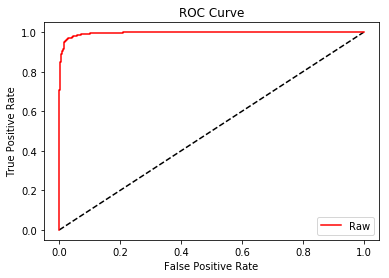

In [46]:
fpr_logistic, tpr_logistic, _ = roc_curve(Y_test_binary, Y_test_prob_logistic)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_logistic, tpr_logistic, label = 'Raw', color = 'r')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

In [49]:
# best logistic regression with l1 penalty 

logistic_l1_cv = GridSearchCV(estimator=LogisticRegression(penalty='l1', solver='liblinear'), 
                              param_grid={'C':[10**-3,10**-2,10**-1,10**0,10**1,10**2,10**3]}, cv=5)
logistic_l1_cv.fit(X_train_LSI, Y_train_binary)

logistic_l1_best = LogisticRegression(C=logistic_l1_cv.best_params_['C'], solver='liblinear')
logistic_l1_best.fit(X_train_LSI, Y_train_binary)

Y_test_label_logisticl1 = logistic_l1_best.predict(X_test_LSI)
Y_test_prob_logisticl1 = logistic_l1_best.decision_function(X_test_LSI)

print('confusion_matrix:\n', confusion_matrix(Y_test_binary, Y_test_label_logisticl1))
print('accuracy:', accuracy_score(Y_test_binary, Y_test_label_logisticl1))
print('recall:', recall_score(Y_test_binary, Y_test_label_logisticl1))
print('precision:', precision_score(Y_test_binary, Y_test_label_logisticl1))
print('f1_score:', f1_score(Y_test_binary, Y_test_label_logisticl1))

confusion_matrix:
 [[1500   60]
 [  42 1548]]
accuracy: 0.9676190476190476
recall: 0.9735849056603774
precision: 0.9626865671641791
f1_score: 0.9681050656660413


In [50]:
pd.DataFrame(logistic_l1_cv.cv_results_)[['param_C','mean_test_score']]

,param_C,mean_test_score
0,0.001,0.495139
1,0.01,0.896875
2,0.1,0.956045
3,1,0.967245
4,10,0.972527
5,100,0.973373
6,1000,0.973373


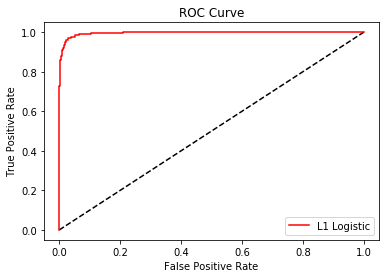

In [51]:
fpr_logisticl1, tpr_logisticl1, _ = roc_curve(Y_test_binary, Y_test_prob_logisticl1)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_logisticl1, tpr_logisticl1, label = 'L1 Logistic', color = 'r')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

In [52]:
# best logistic regression with l2 penalty 

logistic_l2_cv = GridSearchCV(estimator=LogisticRegression(penalty='l2', solver='newton-cg'), 
                              param_grid={'C':[10**-3,10**-2,10**-1,10**0,10**1,10**2,10**3]}, cv=5)
logistic_l2_cv.fit(X_train_LSI, Y_train_binary)

logistic_l2_best = LogisticRegression(C=logistic_l2_cv.best_params_['C'], solver='newton-cg')
logistic_l2_best.fit(X_train_LSI, Y_train_binary)

Y_test_label_logisticl2 = logistic_l2_best.predict(X_test_LSI)
Y_test_prob_logisticl2 = logistic_l2_best.decision_function(X_test_LSI)

print('confusion_matrix:\n', confusion_matrix(Y_test_binary, Y_test_label_logisticl2))
print('accuracy:', accuracy_score(Y_test_binary, Y_test_label_logisticl2))
print('recall:', recall_score(Y_test_binary, Y_test_label_logisticl2))
print('precision:', precision_score(Y_test_binary, Y_test_label_logisticl2))
print('f1_score:', f1_score(Y_test_binary, Y_test_label_logisticl2))

confusion_matrix:
 [[1500   60]
 [  42 1548]]
accuracy: 0.9676190476190476
recall: 0.9735849056603774
precision: 0.9626865671641791
f1_score: 0.9681050656660413


In [53]:
pd.DataFrame(logistic_l2_cv.cv_results_)[['param_C','mean_test_score']]

,param_C,mean_test_score
0,0.001,0.520076
1,0.01,0.945478
2,0.1,0.963652
3,1,0.967877
4,10,0.971682
5,100,0.974217
6,1000,0.972950


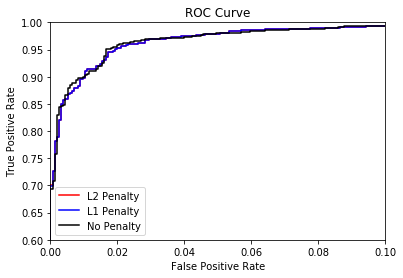

In [55]:
fpr_logisticl2, tpr_logisticl2, _ = roc_curve(Y_test_binary, Y_test_prob_logisticl2)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_logisticl2, tpr_logisticl2, label = 'L2 Penalty', color = 'r')
plt.plot(fpr_logisticl1, tpr_logisticl1, label = 'L1 Penalty', color = 'b')
plt.plot(fpr_logistic, tpr_logistic, label = 'No Penalty', color = 'k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.xlim(0,0.1)
plt.ylim(0.6,1)
plt.legend(loc='best')
plt.show()

# Question 6: Naive Bayes

confusion_matrix:
 [[1217  343]
 [  66 1524]]
accuracy: 0.8701587301587301
recall: 0.9584905660377359
precision: 0.8162828066416711
f1_score: 0.8816893260052068


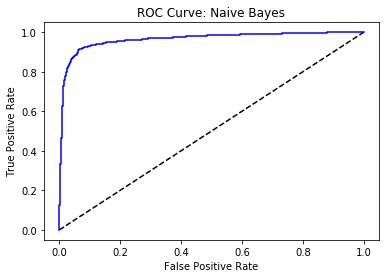

In [56]:
from sklearn.naive_bayes import GaussianNB

gauss_nb = GaussianNB()
gauss_nb.fit(X_train_LSI, Y_train_binary)

Y_test_label_nb = gauss_nb.predict(X_test_LSI)
Y_test_prob_nb = gauss_nb.predict_proba(X_test_LSI)[:,1]


print('confusion_matrix:\n', confusion_matrix(Y_test_binary, Y_test_label_nb))
print('accuracy:', accuracy_score(Y_test_binary, Y_test_label_nb))
print('recall:', recall_score(Y_test_binary, Y_test_label_nb))
print('precision:', precision_score(Y_test_binary, Y_test_label_nb))
print('f1_score:', f1_score(Y_test_binary, Y_test_label_nb))


fpr_nb, tpr_nb, _ = roc_curve(Y_test_binary, Y_test_prob_nb)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_nb, tpr_nb, label = 'Naive Bayes', color = 'b')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Naive Bayes')
plt.show()

# Question 7: Grid Search of Parameters

In [95]:
from sklearn.pipeline import Pipeline

from tempfile import mkdtemp
from shutil import rmtree
from sklearn.externals.joblib import Memory


cachedir = mkdtemp()
# memory = Memory(cachedir=cachedir, verbose=10)


pipeline = Pipeline([
    #('lemmatize', lemmatize()),
    ('vectorize', CountVectorizer(stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('reduceDim', TruncatedSVD(n_components=50)),
    ('clf', SVC(C=svm_cv.best_params_['C'], kernel='linear')),
])

logistic_bestC = logistic_l1_best.C

parameters = [
    {
        'vectorize__min_df': [3,5],
        'reduceDim': [TruncatedSVD(n_components=50), NMF(n_components=50)],
        'clf': [SVC(C=svm_cv.best_params_['C'], kernel='linear'), GaussianNB(),
               LogisticRegression(C=logistic_l1_best.C, penalty = 'l1', solver='liblinear'),
               LogisticRegression(C=logistic_l2_best.C, penalty = 'l2', solver='newton-cg')]
    }
]

In [96]:
grid1 = GridSearchCV(pipeline, cv=5, n_jobs=4, param_grid=parameters, scoring='accuracy')

In [97]:
import time

print("Fitting grid 1...")
t1 = time.time()
grid1.fit(train_dataset_lemmatized, Y_train_binary)
print("Fit grid 1 in %f sec" % (time.time() - t1))

Fitting grid 1...
Fit grid 1 in 180.102572 sec
